<a href="https://colab.research.google.com/github/hermannvargens/california_houses/blob/main/Pre%C3%A7os_de_Casas_da_Calif%C3%B3rnia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ÍNDICE

* **1 Introdução**
* **2 Coleta e descrição dos dados**
* **3 Amostragem**
* **4 Análise Exploratória dos Dados**
* **5 Modelagem**
* **6 Avaliação no conjunto de testes**
* **7 Conclusão**
* **Apêndice A**
* **Apêndice B**

# 1 Introdução

Este projeto tem como objetivo analisar um dataset de preços de casas da Califórnia, nos anos 1990, e apresentar um modelo de previsão para os valores médios das casas.  
Utilizou-se validação cruzada para o treinamento dos dados.  
O modelo de Regressão linear foi comparado com o Random Forest Regressor, utilizando a métrica RMSE.

# 2 Coleta de dados

In [ ]:
#Para cálculos e dataframe
import pandas as pd
import numpy as np

#Para criação de gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

#Para obter uma amostra estratificada, baseada na coluna income_cat
from sklearn.model_selection import StratifiedShuffleSplit

#Para substituir os valores ausentes
from sklearn.impute import SimpleImputer

#para transformar variáveis categóricas em numéricas
from sklearn.preprocessing import OneHotEncoder

#PAra criar pipelines
from sklearn.pipeline import Pipeline

#Para criar pipelines de pré-processamento

from sklearn.compose import ColumnTransformer

#Para realizar validação cruzada

from sklearn.model_selection import cross_val_score

#Para normalizar os dados

from sklearn.preprocessing import StandardScaler

#Para buscar uma melhor avaliação do modelo

from sklearn.model_selection import GridSearchCV

#Para avaliar o erro

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


Dados obtidos de: https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Projetos/California houses/housing.csv')
data = pd.read_csv(r'https://raw.githubusercontent.com/hermannvargens/california_houses/refs/heads/main/housing.csv')

# 3 Análise Exploratória dos Dados

## 3.1 Descrição dos dados

Primeiramente, vamos verificar os tipos de dados contidos em cada coluna.

In [ ]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Vemos que nosso dataset é composto de 9 variáveis numéricas e 1 variável categórica.
Segue a descrição de cada coluna abaixo:

**Numéricas:**

* *longitude*: longitude da localização da região  
* *latitude*: latitude da localização da região  
* *housing_median_age*: idade média dos imóveis da região  
* *total_rooms*: quantidade total de cômodos na região  
* *total_bedrooms*: quantidade total de quartos na região  
* *population*: população da região  
* *households*: quantidade de domicílios na região  
* *median_income*: renda média na região  
* *median_house_value*: preço média da casa na região

**Categórica**

* *ocean_proximity*: proximidade do oceano


Vamos, então, utilizar o método `describe()` para obter informações básicas sobre o dataset.

In [ ]:
data.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


A coluna **ocean_proximity** possui 5 categorias. Vejamos quais são:

In [ ]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Vejamos agora a quantidade de dados ausentes.

In [ ]:
data.isnull().sum()/data.shape[0]*100

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

**Apenas 1% dos dados faltantes na coluna 'total_bedrooms'**

## 3.2 Relação entre as features e a variável target

### 3.2.1 Variável categórica

Primeiro vamos verificar de que forma os valores médios das casas variam em relação a cada categoria em **ocean_proximity**:

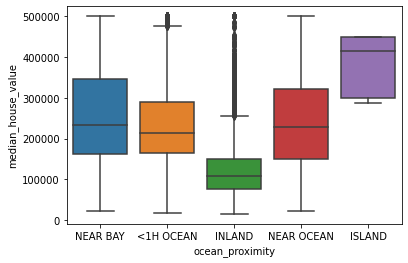

In [ ]:
sns.boxplot(data = data, x = 'ocean_proximity', y='median_house_value')
plt.show()

**Embora a categoria ISLAND possua apenas 5 registros, ela apresenta o maior valor médio.**

Vamos visualizar a distribuição geográfica dos preços médio das casas.

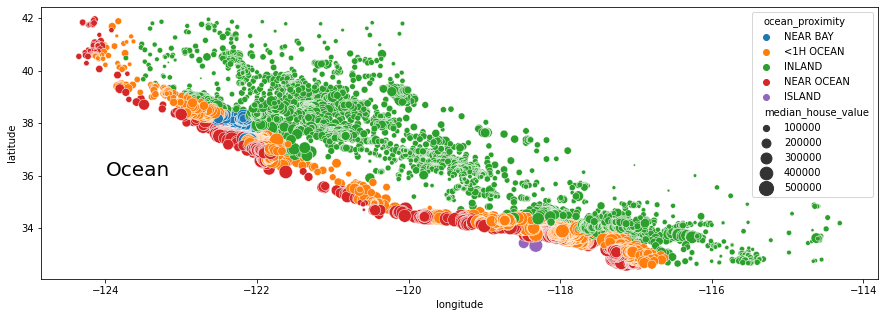

In [ ]:
plt.subplots(figsize=(15,5))

sns.scatterplot(data=data, x='longitude', y='latitude', alpha=1,
                hue='ocean_proximity',
                size='median_house_value', sizes=(5,200),

               ).text(-124,36,'Ocean',fontsize=20)
plt.show()

A partir da visualização do gráfico da distribuição geográfica dos imóveis, podemos ver que os imóveis localizados mais próximos do oceano são os mais caros, confirmado pelo boxplot anterior, onde vemos que a média das casas 'NEAR OCEAN' é levemente mais alta que '<1H OCEAN'

## 3.2.2 Variáveis numéricas

Vamos primeiramente verificar de que forma as variáveis numéricas estão distribuidas:

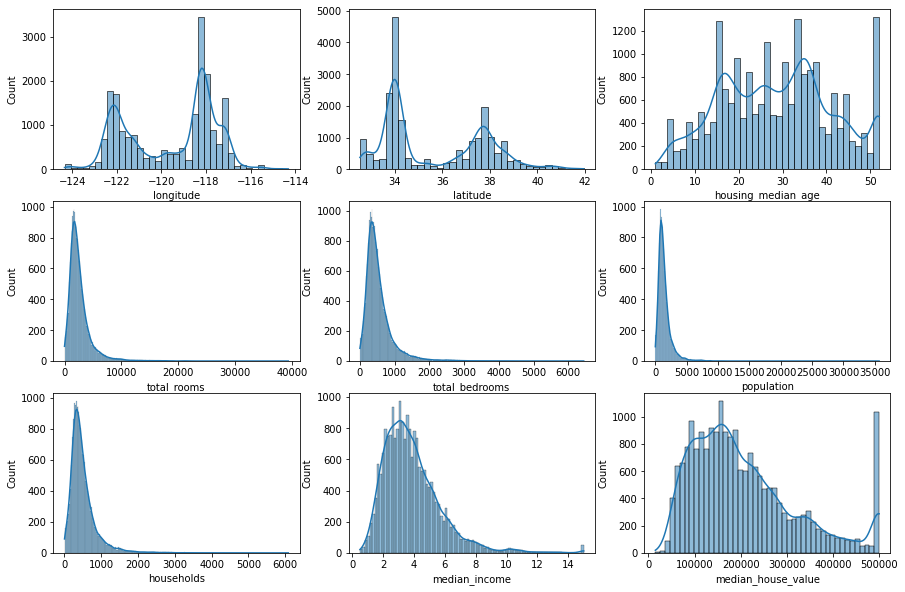

In [ ]:
plt.figure(figsize=(15,10))
for i, col in enumerate(data.columns[:9],1):
  plt.subplot(3,3,i)
  sns.histplot(data[col],kde=True)


Vamos verificar agora, de que forma as variáveis numéricas se relacionam com a variável target('median_house_value').

In [ ]:
data.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Vemos que as colunas 'median_income', 'total_rooms', 'housing_median_age', 'households' e 'latitude', possuem a correlação linear mais forte. Vamos então ver de como elas se distribuem num gráfico de frequência, e sua relação com a variável target ('median_house_value').

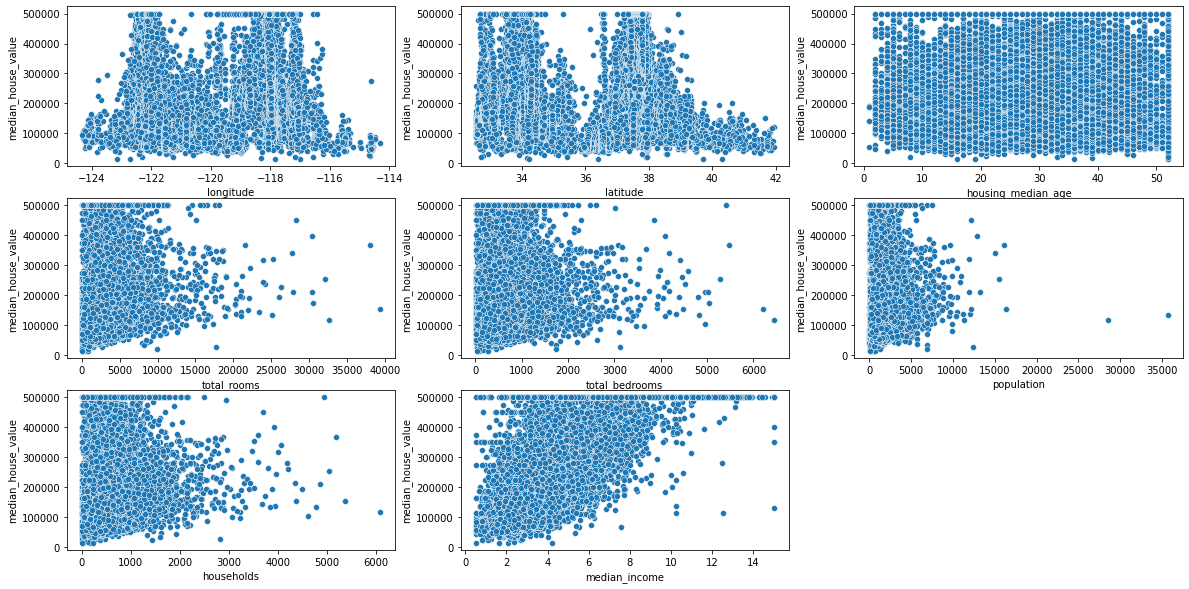

In [ ]:
plt.figure(figsize=(20,10))
for i, col in enumerate(data.columns[:8],1):
  plt.subplot(3,3,i)
  sns.scatterplot(data=data, x=col, y='median_house_value')

Das duas observações acima, distribuição e correlação linear com a variável target, podemos constatar que a coluna **median_income** possui uma alta correlação linear com com **median_house_value** e que , graficamente, **house_median_age** possui baixa correlação.

# 4 Amostragem estratificada

De posse dessas informações, especialmente a alta correlação com **median_income** vamos realizar uma amostragem estratificada, baseada nesse atributo. Primeiramente, vamos categorizar os valores para a renda média (median_income).

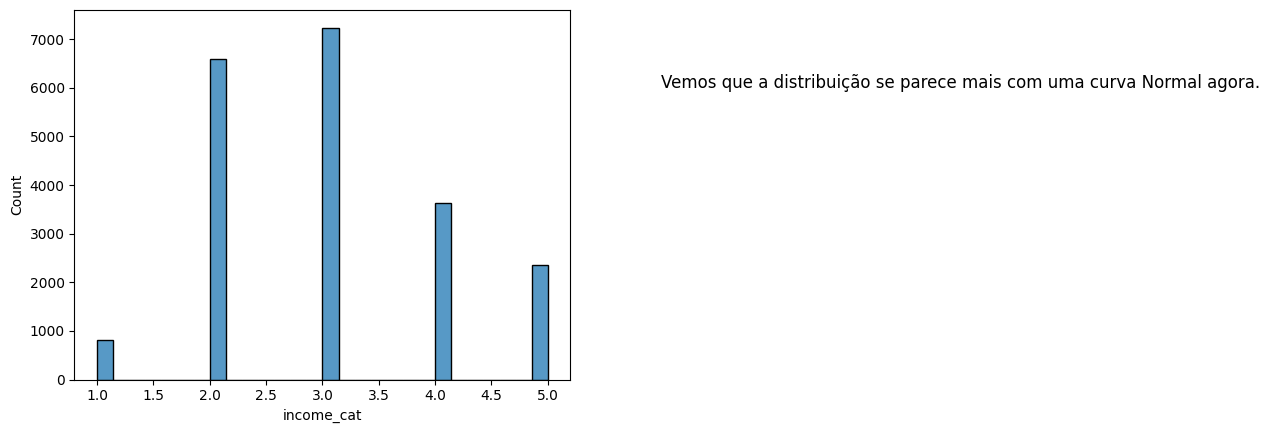

In [ ]:
# 1 - Cria-se uma nova coluna que conterá a categoria de cada renda média (divide-se por 1.5 para reduzir o número de categorias)
data['income_cat'] = np.ceil(data['median_income']/1.5)
# 2 - Vamos criar apenas 5 categorias
data['income_cat'] = data['income_cat'].where(data['income_cat']<5, 5.0)
# 3 - Vamos visualizar o resultado da distribuição da nova coluna
sns.histplot(data=data, x = 'income_cat')

plt.text(6, 6000, 'Vemos que a distribuição se parece mais com uma curva Normal agora.', fontsize=12)
plt.show()

Vamos realizar o split, baseado na coluna 'income_cat', e em seguida, apagá-la.

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data, data["income_cat"]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

print(f'Dados de treino:{train_set.shape}')
print(f'Dados de teste:{test_set.shape}')

Dados de treino:(16512, 11)
Dados de teste:(4128, 11)


In [ ]:
train_set.drop(columns=['income_cat'], inplace = True)
test_set.drop(columns=['income_cat'], inplace = True)

# 5 Pré-processamento dos dados

Apenas para mostrar os procedimentos que serão realizados, vamos mostrar todas as etapas que serão feitas no pré-processamento.
Em seguida, construiremos o Pipeline que será usado no pré-processamento.

*obs: embora não fosse necessário fazer a normalização dos dados, optei por fazê-lo mesmo assim, pois estava treinando Pipelines.

In [ ]:
#Lista de variáveis numéricas
num_var = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
num_var

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [ ]:
#lista de variáveis categóricas
cat_var = ['ocean_proximity']
cat_var


['ocean_proximity']

In [ ]:
target = ['median_house_value']
target

['median_house_value']

## 5.1 Variáveis numéricas

Vamos primeiramente substituir os missing values nas variáveis numéricas, pelo valor da média. Neste caso, temos apenas  na coluna 'total_bedrooms'.

In [ ]:
imputer = SimpleImputer(strategy='median')

In [ ]:
train_set_num = imputer.fit_transform(train_set[num_var])

In [ ]:
train_set_num = pd.DataFrame(train_set_num, columns = num_var)
train_set_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
16510,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [ ]:
train_set_target = pd.DataFrame(train_set[target]).reset_index()
train_set_target.drop(columns=['index'], inplace=True)
train_set_target

,median_house_value
0,72100.0
1,279600.0
2,82700.0
3,112500.0
4,238300.0
...,...
16507,268500.0
16508,90400.0
16509,140400.0
16510,258100.0


## 3.2 Variáveis categóricas

Vamos transformar a coluna de variáveis categóricas, usando o One Hot Encodder:

In [ ]:
encoder = OneHotEncoder()

In [ ]:
train_set_cat = encoder.fit_transform(train_set[cat_var])

In [ ]:
train_set_cat = pd.DataFrame(train_set_cat.toarray(), columns=encoder.categories_[0].tolist())
train_set_cat

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
16507,1.0,0.0,0.0,0.0,0.0
16508,0.0,1.0,0.0,0.0,0.0
16509,1.0,0.0,0.0,0.0,0.0
16510,1.0,0.0,0.0,0.0,0.0


## 3.3 DataFrame preparado

Finalmente, podemos ver abaixo, como será o DataFrame o qual iremos trabalhar, excluindo a coluna 'median_house_value'.

In [ ]:
train_set_prep = pd.concat([train_set_num,train_set_cat, train_set_target], axis=1)
train_set_prep

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,0.0,1.0,0.0,0.0,0.0,72100.0
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,0.0,0.0,0.0,0.0,1.0,279600.0
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,0.0,1.0,0.0,0.0,0.0,82700.0
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,0.0,0.0,0.0,0.0,1.0,112500.0
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,1.0,0.0,0.0,0.0,0.0,238300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,1.0,0.0,0.0,0.0,0.0,268500.0
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,0.0,1.0,0.0,0.0,0.0,90400.0
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,1.0,0.0,0.0,0.0,0.0,140400.0
16510,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,1.0,0.0,0.0,0.0,0.0,258100.0


# 5 Modelagem

## 5.1 Preparação dos dados

Vamos realizar novamente o pré-tratamento dos dados, criando um Pipeline.

In [ ]:
X_train = train_set.drop(columns=['median_house_value'])
y_train = train_set['median_house_value']

E fazer as transformações necessárias, as mesmas que foram feitas anteriormente, através do ColumnTransformer.

In [ ]:
#Para as variáveis numéricas:

num_var = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
num_transf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Para as variáveis categóricas:

cat_var = ['ocean_proximity']
cat_transf = Pipeline([
    ('encoder', OneHotEncoder())
])

In [ ]:
#Pipeline de pré-processamento:

preprocessor = ColumnTransformer([
    ('num', num_transf, num_var),
    ('cat', cat_transf, cat_var)
])

In [ ]:
X_train = preprocessor.fit_transform(X_train)

In [ ]:
pd.DataFrame(X_train)#[0:1]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
1,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
3,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
4,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374,1.0,0.0,0.0,0.0,0.0
16508,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509,0.0,1.0,0.0,0.0,0.0
16509,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475,1.0,0.0,0.0,0.0,0.0
16510,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261,1.0,0.0,0.0,0.0,0.0


## 5.2 Regressão Linear

Vamos realizar validação cruzada na Regressão Linear:

In [ ]:
def rmse_score(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring=rmse_score, cv=5)

In [ ]:
print(f'O RMSE é igual a {lin_scores.mean()} com desvio padrão {lin_scores.std()}')

O RMSE é igual a 69218.45426825911 com desvio padrão 689.501950317617


## 5.3 Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
rfr_scores = cross_val_score(rfr, X_train,y_train, scoring=rmse_score, cv=5)

In [ ]:
print(f'O RMSE é igual a {rfr_scores.mean()} com desvio padrão {rfr_scores.std()}')

O RMSE é igual a 49850.99643231848 com desvio padrão 859.4424843745637


# 6 Avaliação no conjunto de testes

## 6.1 Pré-processamento

In [ ]:
X_test = train_set.drop(columns=['median_house_value'])
y_test = train_set['median_house_value']

In [ ]:
X_test = preprocessor.transform(X_test)
X_test[0:1]

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ]])

## 6.3 Avaliação do modelo

Vamos agora avaliar o erro RMSE no conjunto de teste:

In [ ]:
#Treinando os algoritmos
lin_reg.fit(X_train,y_train)
rfr.fit(X_train,y_train)

#Obtendo as predições
y_pred_lin_reg = lin_reg.predict(X_test)
y_pred_rfr = rfr.predict(X_test)

In [ ]:
rmse_lin_reg = np.sqrt(mean_squared_error(y_test, y_pred_lin_reg))
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))

print(f'Linear Regression RMSE: {rmse_lin_reg:.2f}')
print(f'Random Forest Regressor RMSE: {rmse_rfr:.2f}')

Linear Regression RMSE: 69050.56
Random Forest Regressor RMSE: 18469.85


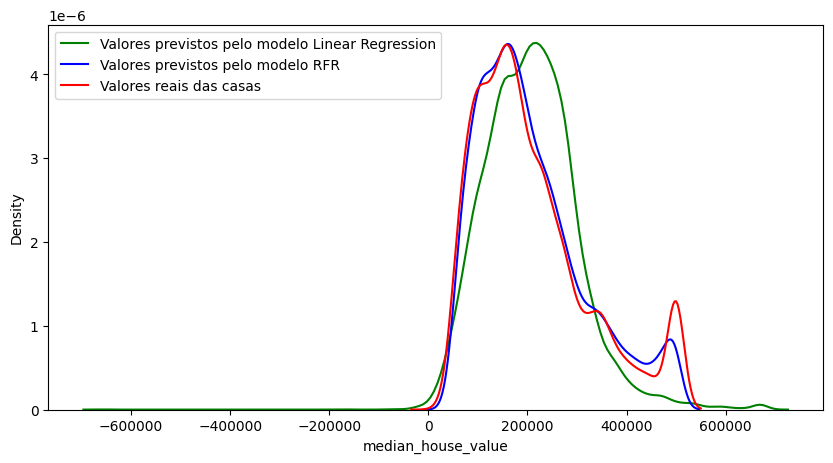

In [ ]:
plt.subplots(figsize=(10,5))
sns.kdeplot(y_pred_lin_reg, color='green')
sns.kdeplot(y_pred_rfr, color='blue')
sns.kdeplot(y_test, color='red')
plt.legend(['Valores previstos pelo modelo Linear Regression','Valores previstos pelo modelo RFR','Valores reais das casas'])
plt.show()

Como era de se esperar, para valores mais altos, próximo 500000, o modelo apresentou os maiores erros.

# 6 Conclusão

O projeto teve como objetivo analisar e modelar o preço médio das casas na Califórnia utilizando um dataset de 1990. Foi realizada uma análise exploratória dos dados, identificando a proximidade do oceano e a renda média como as features mais correlacionadas com o preço das casas. A amostragem estratificada baseada na renda média foi utilizada para dividir os dados em conjuntos de treino e teste.

No pré-processamento, as variáveis numéricas foram imputadas com a mediana e escaladas, e a variável categórica 'ocean_proximity' foi transformada usando OneHotEncoder. Pipelines foram construídos para automatizar essas transformações.

Dois modelos de regressão foram avaliados utilizando validação cruzada no conjunto de treino: Regressão Linear e Random Forest Regressor. O Random Forest Regressor apresentou o menor RMSE no conjunto de treino, indicando um melhor desempenho.

Na avaliação final no conjunto de testes, o Random Forest Regressor confirmou seu bom desempenho, com um RMSE significativamente menor em comparação com a Regressão Linear. O gráfico de distribuição das predições mostrou que o modelo Random Forest Regressor se aproximou mais da distribuição dos valores reais, embora ainda apresente maiores erros para valores de casas mais altos.

Em resumo, o modelo Random Forest Regressor demonstrou ser o mais adequado para a previsão do preço médio das casas neste dataset, com **RMSE=18483.79**.

O modelo **Random Forest Regressor** utilizado nos dados de testeobteve um **RMSE=859.44*